## PH21 Assignment 5

In [1]:
######################################################
#                                                    #
#  Do not commit cache/data files to the repository  #
#                                                    #
######################################################

### In this assignment, you will need to do the following:

1. Determine the error bars on event count datasets
2. Use a collection of events to statistically test if a particle exists given a data channel
3. Fit a model of the particle and background events. Then test against a model with only the background events
3. Determine the likelihood that a particle exists using the errorbars generated from the event dataset.


Background
===========
In the previous assignments (including some of ph20) we have manipulated and fit against datasets where we have either ignored errorbars or had them given to us. Here we must determine the statistical error, given typical "counting statistics" present in all manner of physics experiments, though perhaps most prominently in High Energy Physics experiments using particle colliders.

motivating liturature:

If you are interested in some recent discoveries, take a look at the discovery of tetraquarks from LHCb: https://www.nature.com/articles/s41567-022-01614-y and its figure data at https://www.hepdata.net/record/114871. 

The figure to stare at is https://www.nature.com/articles/s41567-022-01614-y/figures/1.

similarly, look at a recent discovery of a Higgs boson decay channel through Z-gamma decays, https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.132.021803. There, look at Figure 2 https://journals.aps.org/prl/article/10.1103/PhysRevLett.132.021803/figures/2/medium. A more complete history of its detection is given in https://pdg.lbl.gov/2022/reviews/rpp2022-rev-higgs-boson.pdf, which has many more similar plots.

What do both of these analysis have in common? The datasets are essentially plotting a Probability Distribution of event decays. What does that mean? Well a collider only sees the results of a collition as a big collection of resulting particles, their energy and their momentum (via where in the detector they were sensed). From data about the particles detected, various analysis methods "reconstruct" intermediate particles that led to the final observations. 

In the first paper, those intermediate observations were D- and Pi- Mesons. In the second paper, those were a pair of Z-boson and gamma (photon) particles. In both, the total energy of those particular choices of intermediate particles is plotted against the *rate* that events at that energy is seen. New particles tend to create an excess of events at an energy corresponding to the mass of the particle. The trick is to determine what choice of intermediates best detects it. We will assume those things, and just try to perform the detection, given a set of particle event data.

OK.... so how is that done? Well once those particles were reconstructed, essentially they were just put into a big histogram over the total energy of the resulting particles. By using simulation tools, the histograms for Higgs vs. No-higgs or tetra vs. no-tetra could be determined. 

With the data histogrammed, it then becomes a hypothesis test to determine which reality is the most likely. Likelihood is a statistical way of saying "in which reality is the observed data more probable."  

We will explore this using some simple examples, before looking at a dataset that mimics this Higgs channel discovery. I call it that since the Higgs was already discovered, but this newer result is a particularly clean example. 



In [29]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
#import mplhep as hep
import h5py as h5

Load the hdf5 dataset in collision_data.h5. Use h5py. The command line tool "h5ls -R file.h5" can be useful to explore, but you can also use python.

The data is a set of arrays forming a table of collision events. They are split into the individual particles recognized in the collider.

In [30]:
import h5py

# Open the HDF5 file in read mode
filename = 'collision_data.h5'
with h5py.File(filename, 'r') as f:
    # Print all the keys (datasets) in the file
    print("Datasets in the file:")
    for key in f.keys():
        print(key)
    
    # Load each dataset into a NumPy array
    Z_E_GeV    = f['Z_E_GeV'][:]    # Z boson energy in GeV
    Z_phi      = f['Z_phi'][:]      # Z boson phi angle
    Z_theta    = f['Z_theta'][:]    # Z boson theta angle
    gamma_E_GeV = f['gamma_E_GeV'][:]  # Gamma (photon) energy in GeV
    gamma_phi  = f['gamma_phi'][:]   # Gamma phi angle
    gamma_theta = f['gamma_theta'][:]  # Gamma theta angle

# Now you can inspect the loaded data
print("\nExample data:")
print("Z_E_GeV:", Z_E_GeV[:5])        # print first 5 entries for Z_E_GeV
print("gamma_E_GeV:", gamma_E_GeV[:5])  # print first 5 entries for gamma_E_GeV


Datasets in the file:
Z_E_GeV
Z_phi
Z_theta
gamma_E_GeV
gamma_phi
gamma_theta

Example data:
Z_E_GeV: [ 58.8780823    4.18528622  56.3128653   19.09664329 126.04749262]
gamma_E_GeV: [ 64.27507085 121.19008915  55.90935692 112.73518854   2.571126  ]


Make some preliminary histograms to explore the dataset. Transform the dataset into a histogram of the total collision energy. You can use your physics knowledge to try to further filter the data an remove backgrounds (the dataset was made "imperfect" so that there are some additional ways to distinguish background from events.). Further filtering is not necessary, but interesting to further reduce noise.

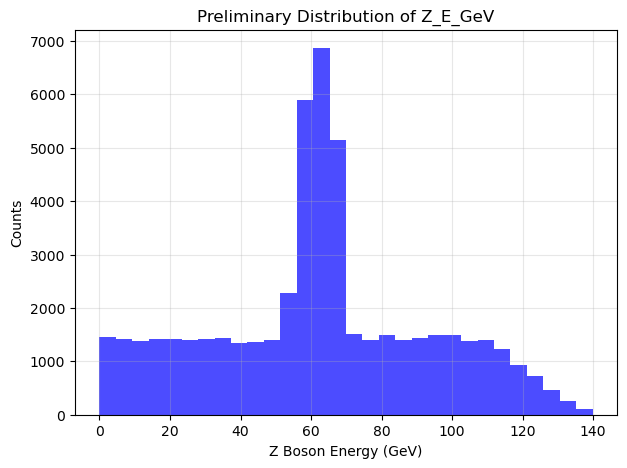

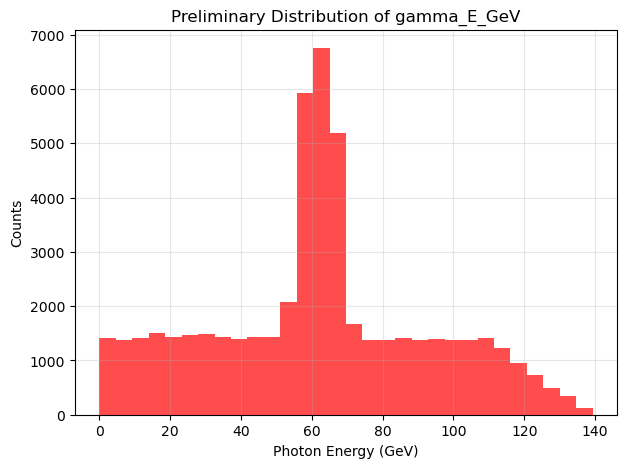

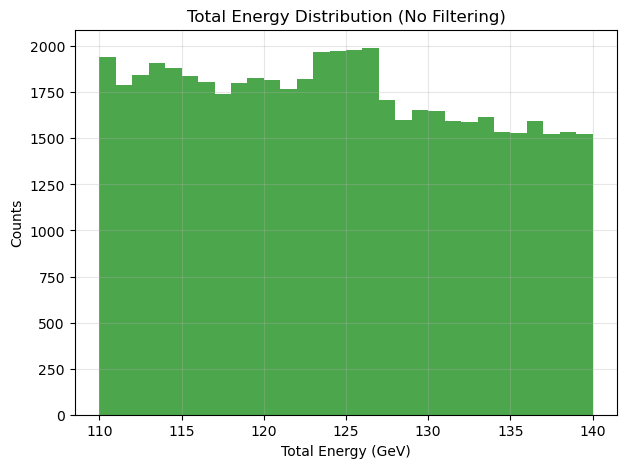

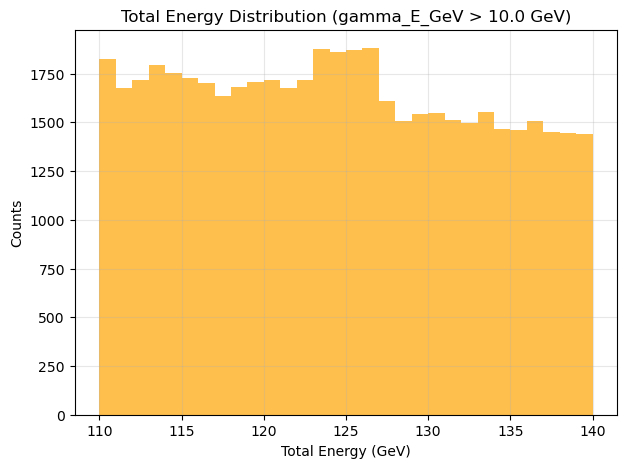

In [32]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the collision data from the HDF5 file

filename = 'collision_data.h5'
with h5py.File(filename, 'r') as f:
    Z_E_GeV     = f['Z_E_GeV'][:]      # Z boson energy (GeV)
    gamma_E_GeV = f['gamma_E_GeV'][:]  # Photon energy (GeV)

# 2. Preliminary histograms for Z_E_GeV and gamma_E_GeV
plt.figure(figsize=(7, 5))
plt.hist(Z_E_GeV, bins=30, alpha=0.7, color='blue')
plt.xlabel('Z Boson Energy (GeV)')
plt.ylabel('Counts')
plt.title('Preliminary Distribution of Z_E_GeV')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7, 5))
plt.hist(gamma_E_GeV, bins=30, alpha=0.7, color='red')
plt.xlabel('Photon Energy (GeV)')
plt.ylabel('Counts')
plt.title('Preliminary Distribution of gamma_E_GeV')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Compute total energy and plot histogram 

total_energy = Z_E_GeV + gamma_E_GeV

plt.figure(figsize=(7, 5))
plt.hist(total_energy, bins=30, alpha=0.7, color='green')
plt.xlabel('Total Energy (GeV)')
plt.ylabel('Counts')
plt.title('Total Energy Distribution (No Filtering)')
plt.grid(True, alpha=0.3)
plt.show()


gamma_threshold = 10.0  # GeV
mask = gamma_E_GeV > gamma_threshold
filtered_total_energy = total_energy[mask]

plt.figure(figsize=(7, 5))
plt.hist(filtered_total_energy, bins=30, alpha=0.7, color='orange')
plt.xlabel('Total Energy (GeV)')
plt.ylabel('Counts')
plt.title(f'Total Energy Distribution (gamma_E_GeV > {gamma_threshold} GeV)')
plt.grid(True, alpha=0.3)
plt.show()


Make a histogram in units of counts, and add the errorbars associated with Poisson counting error. You get to choose the binning you like. Explore the interactive example plots. Should the choice of binning matter?

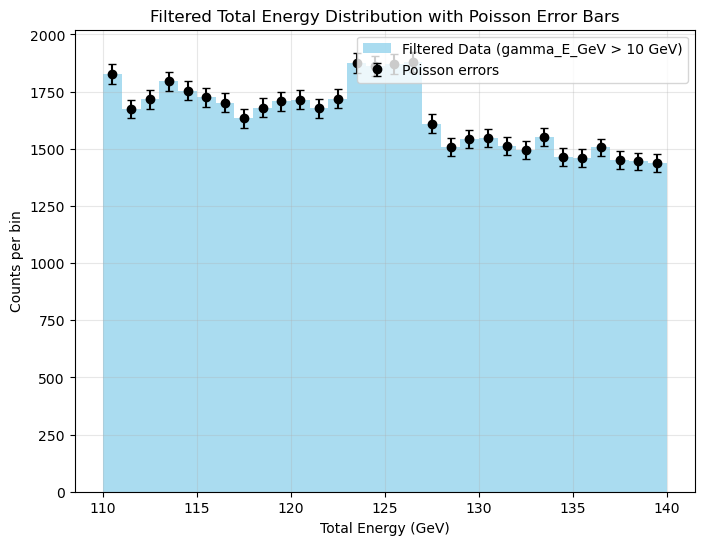

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


# 1. Load the collision data and apply filtering
filename = 'collision_data.h5'
with h5py.File(filename, 'r') as f:
    Z_E_GeV     = f['Z_E_GeV'][:]      # Z boson energy (GeV)
    gamma_E_GeV = f['gamma_E_GeV'][:]  # Photon energy (GeV)

# Compute total energy
total_energy = Z_E_GeV + gamma_E_GeV

# Filter data: only keep events where gamma_E_GeV > 10 GeV
gamma_threshold = 10.0  # GeV
mask = gamma_E_GeV > gamma_threshold
filtered_total_energy = total_energy[mask]

# 2. Make a traditional histogram

plt.figure(figsize=(8, 6))

# Create a histogram of the filtered data
num_bins = 30
counts, bin_edges, patches = plt.hist(
    filtered_total_energy,
    bins=num_bins,
    color='skyblue',
    alpha=0.7,
    label='Filtered Data (gamma_E_GeV > 10 GeV)'
)

# 3. Compute Poisson errors and overlay error bars

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
errors = np.sqrt(counts)  # Poisson errors: sqrt(N)

# Overlay the error bars on top of the histogram
plt.errorbar(
    bin_centers,
    counts,
    yerr=errors,
    fmt='o',
    color='black',
    capsize=3,
    label='Poisson errors'
)

# 4. Labels, legend, and display
plt.xlabel('Total Energy (GeV)')
plt.ylabel('Counts per bin')
plt.title('Filtered Total Energy Distribution with Poisson Error Bars')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


The choice of binning does not change the underlying physics, but it can influence the visual interpretation of your data. Finer bins might show more detailed structure but can suffer from larger statistical fluctuations (i.e. larger relative Poisson error bars), while coarser bins may smooth out features and hide details. 


now calibrate the histogram and its errorbars into event rate units. This means cross-section per GeV of detected energy. The dataset was taken over an integrated luminosity of 
L = 150 fb^-1. That unit is inverse femto-barns. Yes, the barn is a unit of area in physics. It looks like a small area, but it is considered a large cross section. That means that every individual event in the dataset has a cross section of 1/L, and when you accumulate N of them, the cross section of the "pool" of events is N/L.

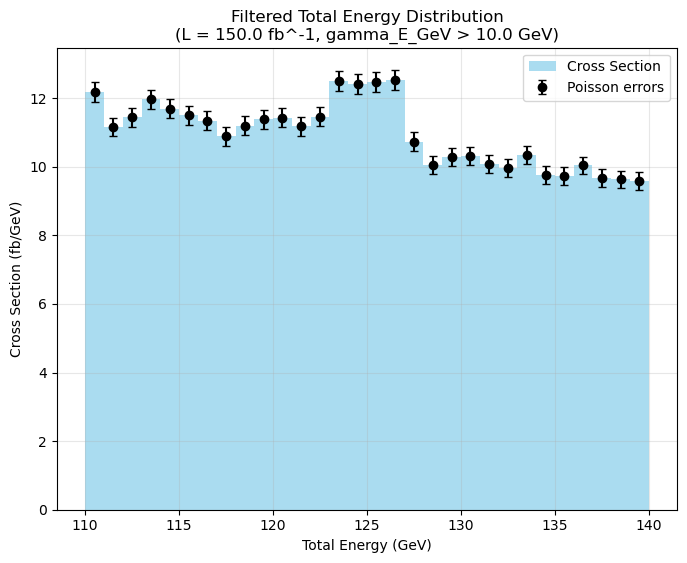

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the collision data and apply filtering

filename = 'collision_data.h5'
with h5py.File(filename, 'r') as f:
    Z_E_GeV     = f['Z_E_GeV'][:]      
    gamma_E_GeV = f['gamma_E_GeV'][:]  

# Compute total energy
total_energy = Z_E_GeV + gamma_E_GeV

# Filter data: only keep events where gamma_E_GeV > 10 GeV
gamma_threshold = 10.0  
mask = gamma_E_GeV > gamma_threshold
filtered_total_energy = total_energy[mask]


L = 150.0  # Integrated luminosity in fb^-1
num_bins = 30

# Make a standard histogram first
counts, bin_edges = np.histogram(filtered_total_energy, bins=num_bins)

# Bin centers and widths
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widths = bin_edges[1:] - bin_edges[:-1]


# Each event corresponds to a cross section of 1/L (in fb).
# Dividing by the bin width in GeV yields fb/GeV.
cross_sections = counts / (L * bin_widths)
cross_sections_errors = np.sqrt(counts) / (L * bin_widths)

plt.figure(figsize=(8, 6))

# Plot the cross section as a bar chart
plt.bar(
    bin_centers,
    cross_sections,
    width=bin_widths,
    color='skyblue',
    alpha=0.7,
    label='Cross Section'
)

# Overlay Poisson error bars
plt.errorbar(
    bin_centers,
    cross_sections,
    yerr=cross_sections_errors,
    fmt='o',
    color='black',
    capsize=3,
    label='Poisson errors'
)

plt.xlabel('Total Energy (GeV)')
plt.ylabel('Cross Section (fb/GeV)')
plt.title(f'Filtered Total Energy Distribution\n(L = {L} fb^-1, gamma_E_GeV > {gamma_threshold} GeV)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Now create a model background and event process. The background can be a rate in the Lorenzian tail of many low-energy processes

$R_{bg}(E) = R_{scale} * \frac{E_{scale}}{E}$

$R_{higgs}(E) = \frac{1}{\pi}\frac{\Delta E}{\Delta E^2 + (E - mc^2)^2}$ 

$R_{joint}(E) = R_{bg}(E) + (A*B)*R_{higgs}(E)$

Where A is the Higgs formation cross section (units of area) and B is an unknown representing the branching ratio into the Higgs measurement channel of interest. Note that this measurement can only measure the product, so you can call that $C=(A \cdot B)$ which is the cross section for the $Z\gamma$ decay channel. $\Delta E$ in principle measures the lifetime/energy width of the Higgs, but here is limited by the resolution of the detection system, which smears out the event energies.

You will then create residuals by subtracting the data from the model and weighting by the error bars. Use scipy.optimize.least_squares to fit the unknown parameters of both the particle and backgrounds.

Perform this minimization twice, once using the joint rate, and once using a rate with only the background.

Plot all of these things together, and print all of the parameters.


Background-only fit parameters:
  R_scale = 44.6416
  E_scale = 30.4521

Joint fit parameters (background + Higgs):
  R_scale = 61.6854
  E_scale = 21.2513
  M       = 124.9754 GeV
  DeltaE  = 1.8908 GeV
  C       = 1.3664e+01 fb/GeV? (effective amplitude)


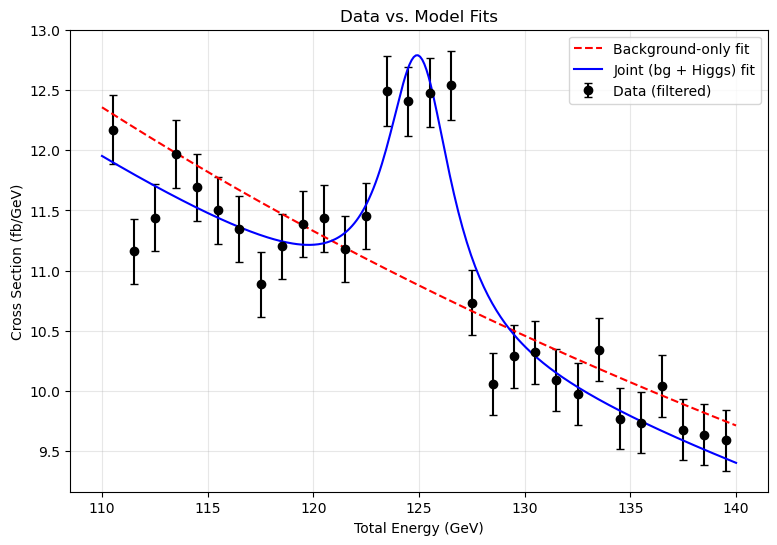

In [38]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

filename = 'collision_data.h5'
with h5py.File(filename, 'r') as f:
    Z_E_GeV     = f['Z_E_GeV'][:]
    gamma_E_GeV = f['gamma_E_GeV'][:]

total_energy = Z_E_GeV + gamma_E_GeV
mask = (gamma_E_GeV > 10.0)  # Example cut
filtered_total_energy = total_energy[mask]


L = 150.0  # fb^-1
num_bins = 30
counts, bin_edges = np.histogram(filtered_total_energy, bins=num_bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Cross section in each bin: sigma_i = counts_i / (L * bin_width_i)
cross_sections = counts / (L * bin_widths)
# Poisson error: sqrt(counts_i) / (L * bin_width_i)
cross_sections_errors = np.sqrt(counts) / (L * bin_widths)


def model_bg(E, R_scale, E_scale):
    """
    Background rate: R_bg(E) = R_scale * (E_scale / E).
    Units and magnitude will be determined by the fit.
    """
    return R_scale * (E_scale / E)

def model_higgs(E, M, DeltaE):
    """
    Higgs resonance (Lorentzian) with center M, width DeltaE:
    R_higgs(E) = (1/pi) * [DeltaE / (DeltaE^2 + (E - M)^2)]
    """
    return (1.0 / np.pi) * (DeltaE / (DeltaE**2 + (E - M)**2))

def model_joint(E, params):
    """
    Joint model = background + Higgs resonance.
    params = [R_scale, E_scale, M, DeltaE, C]
    """
    R_scale, E_scale, M, DeltaE, C = params
    return model_bg(E, R_scale, E_scale) + C * model_higgs(E, M, DeltaE)



def residual_bg(p, E, data, errors):
    """
    Residual for background-only model.
    p = [R_scale, E_scale]
    """
    R_scale, E_scale = p
    model_vals = model_bg(E, R_scale, E_scale)
    return (model_vals - data) / errors

def residual_joint(p, E, data, errors):
    """
    Residual for background + Higgs model.
    p = [R_scale, E_scale, M, DeltaE, C]
    """
    model_vals = model_joint(E, p)
    return (model_vals - data) / errors


p0_bg = [1.0, 1.0]  # initial guess for [R_scale, E_scale]
result_bg = least_squares(
    residual_bg,
    p0_bg,
    args=(bin_centers, cross_sections, cross_sections_errors)
)
pfit_bg = result_bg.x
print("Background-only fit parameters:")
print(f"  R_scale = {pfit_bg[0]:.4f}")
print(f"  E_scale = {pfit_bg[1]:.4f}")

p0_joint = [1.0, 1.0, 125.0, 2.0, 1.0]  # [R_scale, E_scale, M, DeltaE, C]
result_joint = least_squares(
    residual_joint,
    p0_joint,
    args=(bin_centers, cross_sections, cross_sections_errors)
)
pfit_joint = result_joint.x
print("\nJoint fit parameters (background + Higgs):")
print(f"  R_scale = {pfit_joint[0]:.4f}")
print(f"  E_scale = {pfit_joint[1]:.4f}")
print(f"  M       = {pfit_joint[2]:.4f} GeV")
print(f"  DeltaE  = {pfit_joint[3]:.4f} GeV")
print(f"  C       = {pfit_joint[4]:.4e} fb/GeV? (effective amplitude)")


plt.figure(figsize=(9, 6))

# Plot data
plt.errorbar(
    bin_centers, cross_sections, yerr=cross_sections_errors,
    fmt='o', capsize=3, color='black',
    label='Data (filtered)'
)

# Define a finer grid for smooth model curves
E_plot = np.linspace(bin_edges[0], bin_edges[-1], 300)

# (A) Background-only model
bg_curve = model_bg(E_plot, pfit_bg[0], pfit_bg[1])
plt.plot(E_plot, bg_curve, 'r--', label='Background-only fit')

# (B) Joint model
joint_curve = model_joint(E_plot, pfit_joint)
plt.plot(E_plot, joint_curve, 'b-', label='Joint (bg + Higgs) fit')

plt.xlabel('Total Energy (GeV)')
plt.ylabel('Cross Section (fb/GeV)')
plt.title('Data vs. Model Fits')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Now get the array of residuals for both fits. This array has a statistical interpretation. Each data point represents a random variable. In the low-N limit, this variable has a binomial distribution. If you used very fine binning, you may have to consider that. For course binning, the N in each bit is large, N>30, where the central limit theorem kicks in and the Binomial distribution can be approximated as a Gaussian with a standard deviation equal to the error bar. Since the residuals are normalized by the error bar, they should look like standard normal distributions.

Histogram the residuals of each fit and check that they appear Gaussian distributed with the correct scaling. (You could in principle put error bars on this histogram too.. and that is useful to test the Guassianaity of your noise process. No need here). This is a very standard data quality test to check an error model

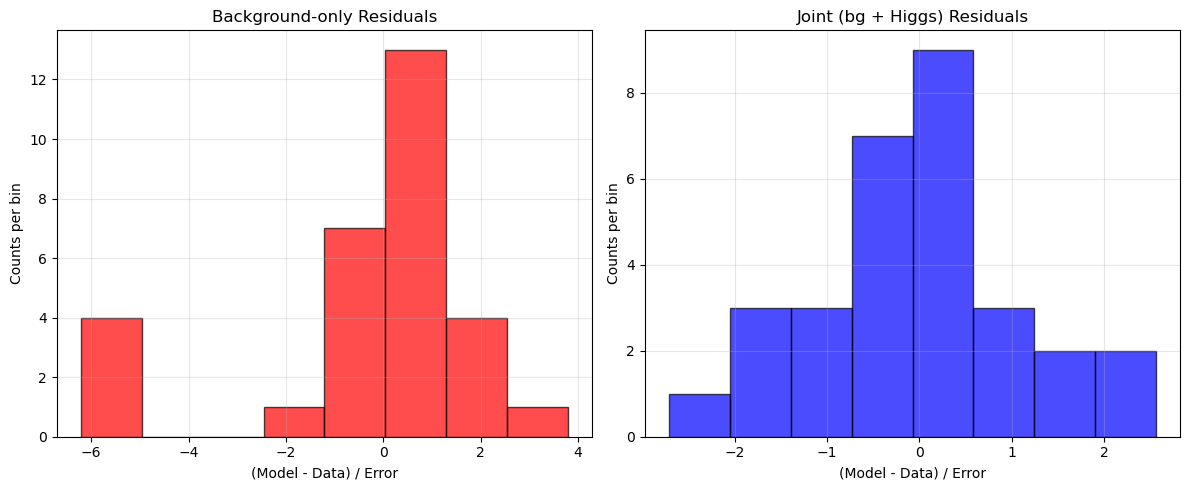

In [39]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import scipy.stats as st


filename = 'collision_data.h5'
with h5py.File(filename, 'r') as f:
    Z_E_GeV     = f['Z_E_GeV'][:]
    gamma_E_GeV = f['gamma_E_GeV'][:]

total_energy = Z_E_GeV + gamma_E_GeV
mask = (gamma_E_GeV > 10.0)  # e.g. photon-energy cut
filtered_total_energy = total_energy[mask]

L = 150.0  # fb^-1 integrated luminosity
num_bins = 30
counts, bin_edges = np.histogram(filtered_total_energy, bins=num_bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widths = bin_edges[1:] - bin_edges[:-1]

cross_sections = counts / (L * bin_widths)                 # fb/GeV
cross_sections_errors = np.sqrt(counts) / (L * bin_widths)  # fb/GeV


def model_bg(E, R_scale, E_scale):
    """Background: R_bg(E) = R_scale * (E_scale / E)."""
    return R_scale * (E_scale / E)

def model_higgs(E, M, DeltaE):
    """
    Higgs resonance (Lorentzian):
      R_higgs(E) = (1/pi) * [DeltaE / (DeltaE^2 + (E - M)^2)]
    """
    return (1.0 / np.pi) * (DeltaE / (DeltaE**2 + (E - M)**2))

def model_joint(E, params):
    """
    Joint = background + Higgs.
    params = [R_scale, E_scale, M, DeltaE, C]
    """
    R_scale, E_scale, M, DeltaE, C = params
    return model_bg(E, R_scale, E_scale) + C * model_higgs(E, M, DeltaE)

def residual_bg(p, E, data, errors):
    """Residual for background-only: (model - data) / error."""
    R_scale, E_scale = p
    model_vals = model_bg(E, R_scale, E_scale)
    return (model_vals - data) / errors

def residual_joint(p, E, data, errors):
    """Residual for joint (bg + Higgs): (model - data) / error."""
    model_vals = model_joint(E, p)
    return (model_vals - data) / errors


# (A) Background-only
p0_bg = [1.0, 1.0]  
res_bg_fit = least_squares(
    residual_bg, p0_bg, args=(bin_centers, cross_sections, cross_sections_errors)
)
pfit_bg = res_bg_fit.x

# (B) Joint (bg + Higgs)
p0_joint = [1.0, 1.0, 125.0, 2.0, 1.0]  
res_joint_fit = least_squares(
    residual_joint, p0_joint, args=(bin_centers, cross_sections, cross_sections_errors)
)
pfit_joint = res_joint_fit.x


res_bg_vals = residual_bg(pfit_bg, bin_centers, cross_sections, cross_sections_errors)
res_joint_vals = residual_joint(pfit_joint, bin_centers, cross_sections, cross_sections_errors)


plt.figure(figsize=(12, 5))

# Background-only residuals
plt.subplot(1, 2, 1)
plt.hist(res_bg_vals, bins=8, alpha=0.7, color='red', edgecolor='black')
plt.title('Background-only Residuals')
plt.xlabel('(Model - Data) / Error')
plt.ylabel('Counts per bin')
plt.grid(alpha=0.3)

# Joint model residuals
plt.subplot(1, 2, 2)
plt.hist(res_joint_vals, bins=8, alpha=0.7, color='blue', edgecolor='black')
plt.title('Joint (bg + Higgs) Residuals')
plt.xlabel('(Model - Data) / Error')
plt.ylabel('Counts per bin')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()




Now, we want to determine the probability of either measurement. Since each residual represents a random normal value, you can plug it into the Gaussian distribution and get its probability. The total probability is the product. Note that for both measurements, this will seem like a tiny number! In fact, as you take more and more measurements, the probability of any observation gets smaller. Two things help: A) compute the log of the probability. This means just don't evaluate the exponential in the normal distribution (or do, but then log it). You can then sum to logs to find the total log-likelihood of either measurement. B) Now what we want to test is simply which measurement is relatively more likely. This is done by taking the ratio of the likelihoods, or the difference of the logs.

https://en.wikipedia.org/wiki/Likelihood-ratio_test (technically, this is not a simple hypothesis test, since we also fit parameters, but assume it is "Case of simple hypotheses")

The associated Neyman–Pearson lemma indicates that the likelihood ratio test is an optimal statistic, which means that you might as well do it this way. This test is great because it works well even for more complex distributions than Gaussians, and also works when the distributions are experimentally determined or modelled using sampling (a topic for ph22).

Interestingly, once you take the ratio, or difference of the logs, this issue that either/both measurements seem less likely with more data or more residuals goes away. This is like renormalization for statisticitians. It occurs because much of the data is only sensitive to the background model, which is common between the two hypotheses. Thus if each reality appears less likely due to more data, only the contribution where the probability model changes doesn't subtract away.

The actual statistical test is to set a threshold for the likelyhood ratio. To do that, you need to establish a model of the probability distribution of the likelihood ratio itself, assuming the null hypothesis (here, the Background-only no-Higgs rate model).

We aren't going to do that here. An exact derivation would find that the distribution of the likelyhood ratio is related to the https://en.wikipedia.org/wiki/Chi-squared_distribution. It isn't exactly related, since the likelyhood ratio implicitly uses an *optimal weighting* of the data (this is really cool). The optimal weighting indicates that the effective number of degress of freedom is fractional.

The more typical thing done in experiments is to then randomly sample and create fake virtual datasets with which to make histograms of the likelihood ratio! That way noone needs fancy computations, and indeed exceedingly complex interractions between physics, statistics, and measurement biases can all be accounted for.

That's a long lesson.. For this relatively simple Guassian residuals model, compute the log-likelihood ratio. That will also be the square of the standard error of the final distribution. Thus if you take the square root, you'll get the significance, in standard deviations. Hopefully your measurement of the Higgs is over 5-sigma (log likelihood ratio threshold of 25).

